# Cleaning US Census Data

## Inspect the Data

In [ ]:
# This project focuses on cleaning and preprocessing a dataset using Pandas in Python. 
# The goal is to prepare the data for further analysis or modeling by handling missing values, outliers, and other common data quality issues.

In [1]:
import zipfile
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Unzipping the file
with zipfile.ZipFile('USCensus.zip', 'r') as zip_ref:
    zip_ref.extractall('USCensus')

# Get list of all files in the extracted folder
file_list = os.listdir('USCensus')

# Load the first CSV file into a DataFrame as an example
csv_file = [file for file in file_list if file.endswith('.csv')][0]  # Adjust to select the correct file if needed
df = pd.read_csv(f'USCensus/{csv_file}')

# Display the first few rows to inspect the data
print(df.head())

   CensusTract    State   County  TotalPop   Men  Women  Hispanic  White  \
0   1001020100  Alabama  Autauga      1948   940   1008       0.9   87.4   
1   1001020200  Alabama  Autauga      2156  1059   1097       0.8   40.4   
2   1001020300  Alabama  Autauga      2968  1364   1604       0.0   74.5   
3   1001020400  Alabama  Autauga      4423  2172   2251      10.5   82.8   
4   1001020500  Alabama  Autauga     10763  4922   5841       0.7   68.5   

   Black  Native  ...  Walk  OtherTransp  WorkAtHome  MeanCommute  Employed  \
0    7.7     0.3  ...   0.5          2.3         2.1         25.0       943   
1   53.3     0.0  ...   0.0          0.7         0.0         23.4       753   
2   18.6     0.5  ...   0.0          0.0         2.5         19.6      1373   
3    3.7     1.6  ...   0.0          2.6         1.6         25.3      1782   
4   24.8     0.0  ...   0.0          0.6         0.9         24.8      5037   

   PrivateWork  PublicWork  SelfEmployed  FamilyWork  Unemployment  

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74001 entries, 0 to 74000
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CensusTract      74001 non-null  int64  
 1   State            74001 non-null  object 
 2   County           74001 non-null  object 
 3   TotalPop         74001 non-null  int64  
 4   Men              74001 non-null  int64  
 5   Women            74001 non-null  int64  
 6   Hispanic         73311 non-null  float64
 7   White            73311 non-null  float64
 8   Black            73311 non-null  float64
 9   Native           73311 non-null  float64
 10  Asian            73311 non-null  float64
 11  Pacific          73311 non-null  float64
 12  Citizen          74001 non-null  int64  
 13  Income           72901 non-null  float64
 14  IncomeErr        72901 non-null  float64
 15  IncomePerCap     73261 non-null  float64
 16  IncomePerCapErr  73261 non-null  float64
 17  Poverty     

In [4]:
print(df.describe())

        CensusTract      TotalPop           Men         Women      Hispanic  \
count  7.400100e+04  74001.000000  74001.000000  74001.000000  73311.000000   
mean   2.839113e+10   4325.591465   2127.648816   2197.942649     16.862810   
std    1.647593e+10   2129.306903   1072.332031   1095.730931     22.940695   
min    1.001020e+09      0.000000      0.000000      0.000000      0.000000   
25%    1.303901e+10   2891.000000   1409.000000   1461.000000      2.400000   
50%    2.804700e+10   4063.000000   1986.000000   2066.000000      7.000000   
75%    4.200341e+10   5442.000000   2674.000000   2774.000000     20.400000   
max    7.215375e+10  53812.000000  27962.000000  27250.000000    100.000000   

              White         Black        Native         Asian       Pacific  \
count  73311.000000  73311.000000  73311.000000  73311.000000  73311.000000   
mean      62.032106     13.272581      0.727726      4.588253      0.145012   
std       30.684152     21.762483      4.488340    

In [5]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values[missing_values > 0])

Missing Values:
 Hispanic            690
White               690
Black               690
Native              690
Asian               690
Pacific             690
Income             1100
IncomeErr          1100
IncomePerCap        740
IncomePerCapErr     740
Poverty             835
ChildPoverty       1118
Professional        807
Service             807
Office              807
Construction        807
Production          807
Drive               797
Carpool             797
Transit             797
Walk                797
OtherTransp         797
WorkAtHome          797
MeanCommute         949
PrivateWork         807
PublicWork          807
SelfEmployed        807
FamilyWork          807
Unemployment        802
dtype: int64


In [ ]:
# Interpretation

# Missing Values: Some columns like Hispanic, Income, and Unemployment have missing values (nulls). 
# You may want to handle these missing values before plotting.
# You can either remove rows with missing values or fill them with a relevant statistic (mean, median, etc.) depending on the analysis.

# Data Types: The data types seem appropriate, but make sure you're clear on which columns are numeric (float64, int64) and which ones are categorical (object). For example, State and County are categorical, while Income and TotalPop are numeric.
# Scale Differences: Some values might have different scales, such as TotalPop versus percentages like Hispanic, White, etc. This may require normalization or thoughtful axis limits when visualizing.

# Outliers: Consider checking for outliers in columns like Income, Unemployment, and Poverty. Outliers could skew visualizations, so you might want to detect and address them before plotting.

Outliers detected in Income: 2987
Outliers detected in Poverty: 2786
Outliers detected in Unemployment: 3422
Outliers detected in TotalPop: 1493
Outliers detected in Employed: 1521


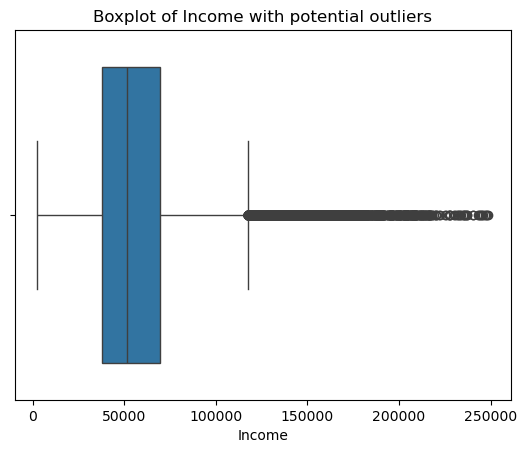

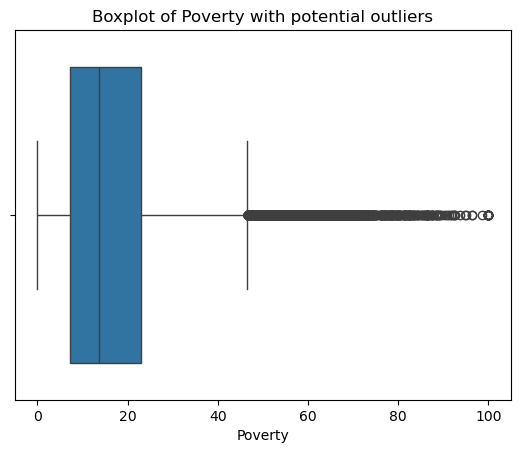

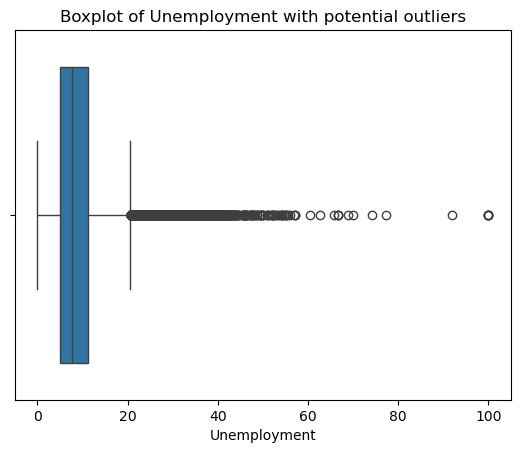

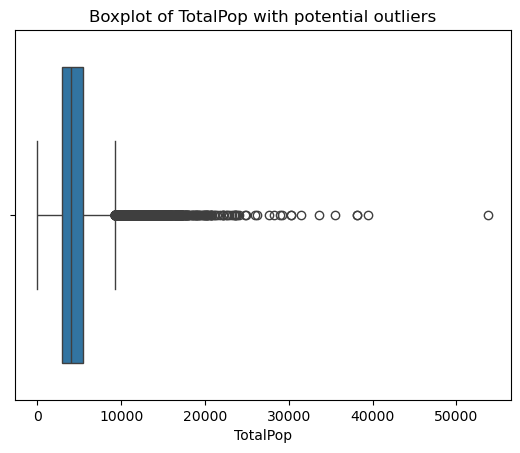

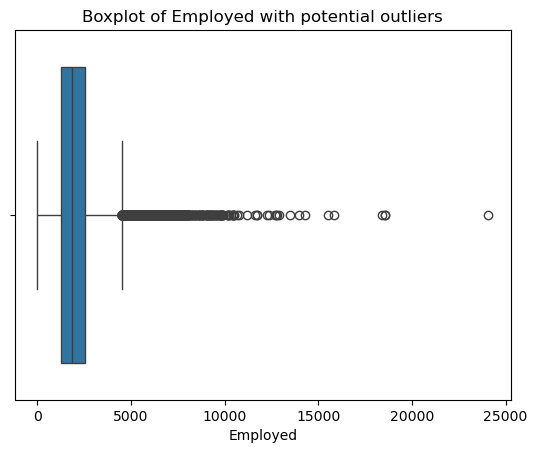

In [7]:
# Handle missing values
def handle_missing_values(df):
    # Fill numeric columns with mean
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())
    
    # Fill categorical columns with mode
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if df[col].isnull().sum() > 0:  # Ensure there are missing values
            df[col].fillna(df[col].mode()[0], inplace=True)

    return df

df = handle_missing_values(df)

# Outlier detection using IQR method
def detect_outliers(df, column, iqr_multiplier=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - iqr_multiplier * IQR
    upper_bound = Q3 + iqr_multiplier * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Check for outliers in specified columns
columns_to_check = ['Income', 'Poverty', 'Unemployment', 'TotalPop', 'Employed']
outlier_info = {}

for col in columns_to_check:
    outliers = detect_outliers(df, col)
    outlier_info[col] = len(outliers)
    print(f"Outliers detected in {col}: {len(outliers)}")

# Visualization: Display boxplots for columns with outliers
def visualize_outliers(df, columns):
    for col in columns:
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot of {col} with potential outliers')
        plt.show()

visualize_outliers(df, columns_to_check)

In [8]:
# Handling Outliers (Capping Method)

# Function to cap outliers at a given percentile
def cap_outliers(df, column, lower_percentile=0.01, upper_percentile=0.99):
    lower_bound = df[column].quantile(lower_percentile)
    upper_bound = df[column].quantile(upper_percentile)
    
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    print(f"{column}: Capped outliers at {lower_percentile * 100}% and {upper_percentile * 100}%")
    
    return df

# Apply capping for the columns identified with outliers
columns_to_cap = ['Income', 'Poverty', 'Unemployment', 'TotalPop', 'Employed']

for col in columns_to_cap:
    df = cap_outliers(df, col)

Income: Capped outliers at 1.0% and 99.0%
Poverty: Capped outliers at 1.0% and 99.0%
Unemployment: Capped outliers at 1.0% and 99.0%
TotalPop: Capped outliers at 1.0% and 99.0%
Employed: Capped outliers at 1.0% and 99.0%


In [ ]:
#  Exploratory Data Analysis (EDA)

In [ ]:
# Visualizations

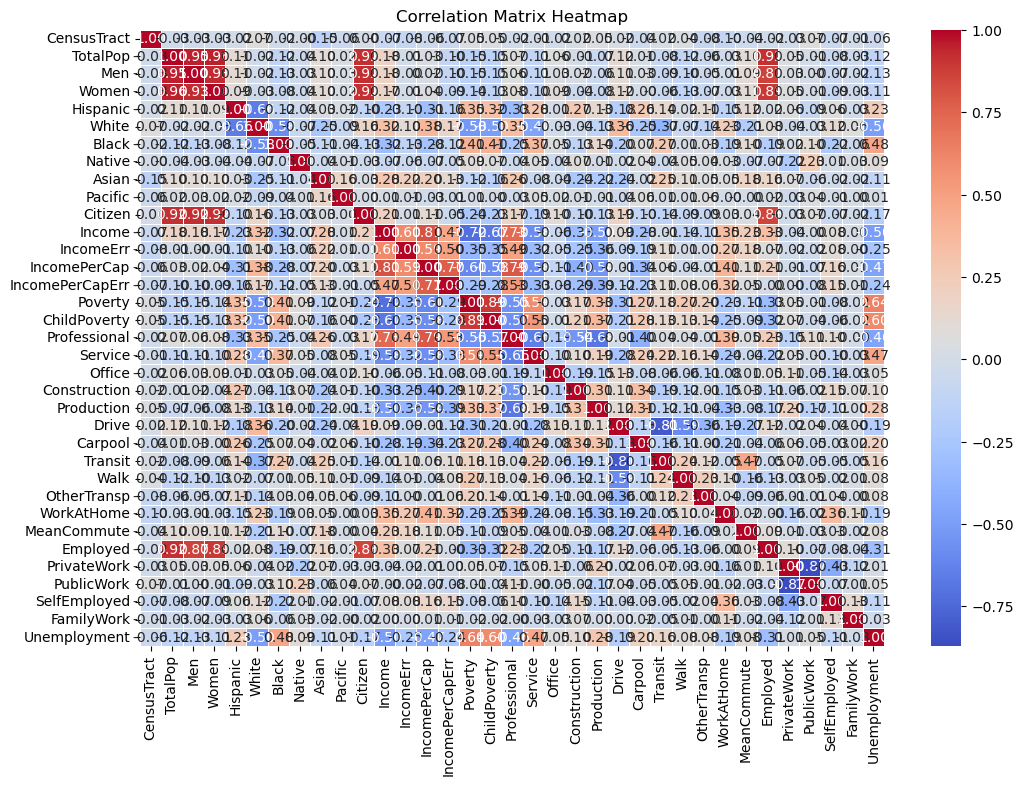

In [11]:
# Correlation matrix and heatmap for numeric columns only
plt.figure(figsize=(12, 8))

# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
corr_matrix = numeric_df.corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

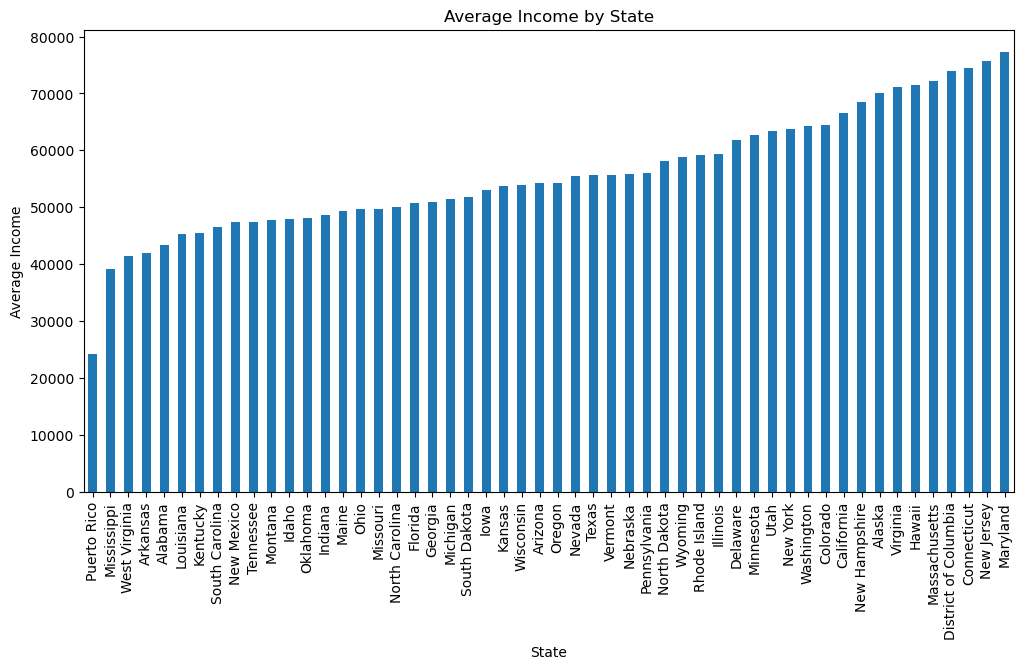

In [12]:
# Group by state and calculate the average income
avg_income_by_state = df.groupby('State')['Income'].mean().sort_values()

# Plot a bar chart of average income by state
plt.figure(figsize=(12, 6))
avg_income_by_state.plot(kind='bar')
plt.title('Average Income by State')
plt.ylabel('Average Income')
plt.xticks(rotation=90)
plt.show()

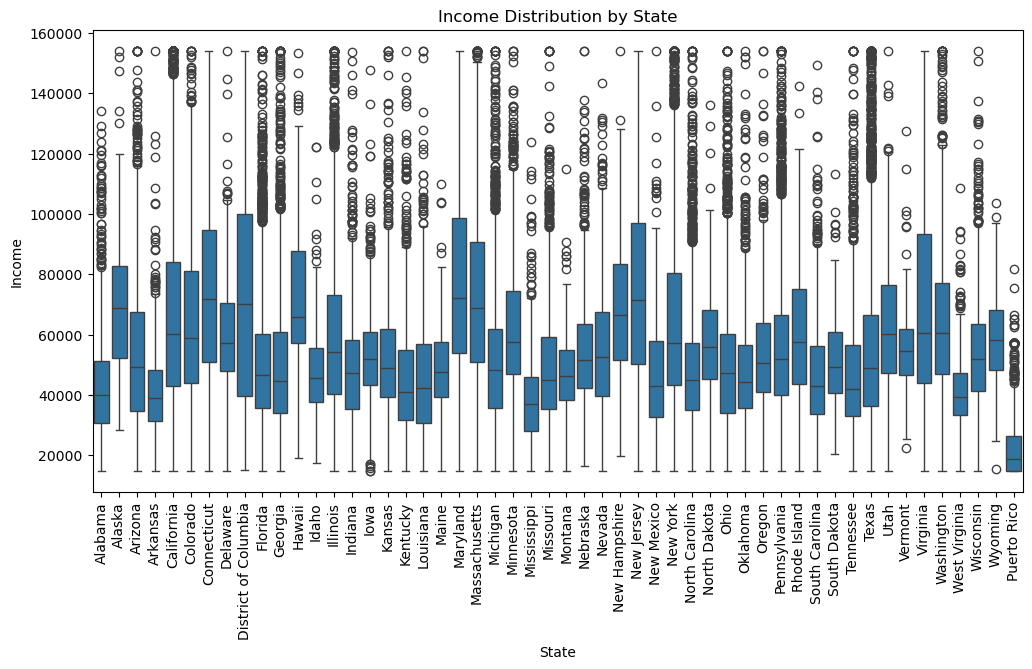

In [13]:
# Box Plots to Explore Distribution and Outliers by Group

# Box plot: Income distribution by State
plt.figure(figsize=(12, 6))
sns.boxplot(x='State', y='Income', data=df)
plt.xticks(rotation=90)
plt.title('Income Distribution by State')
plt.ylabel('Income')
plt.show()

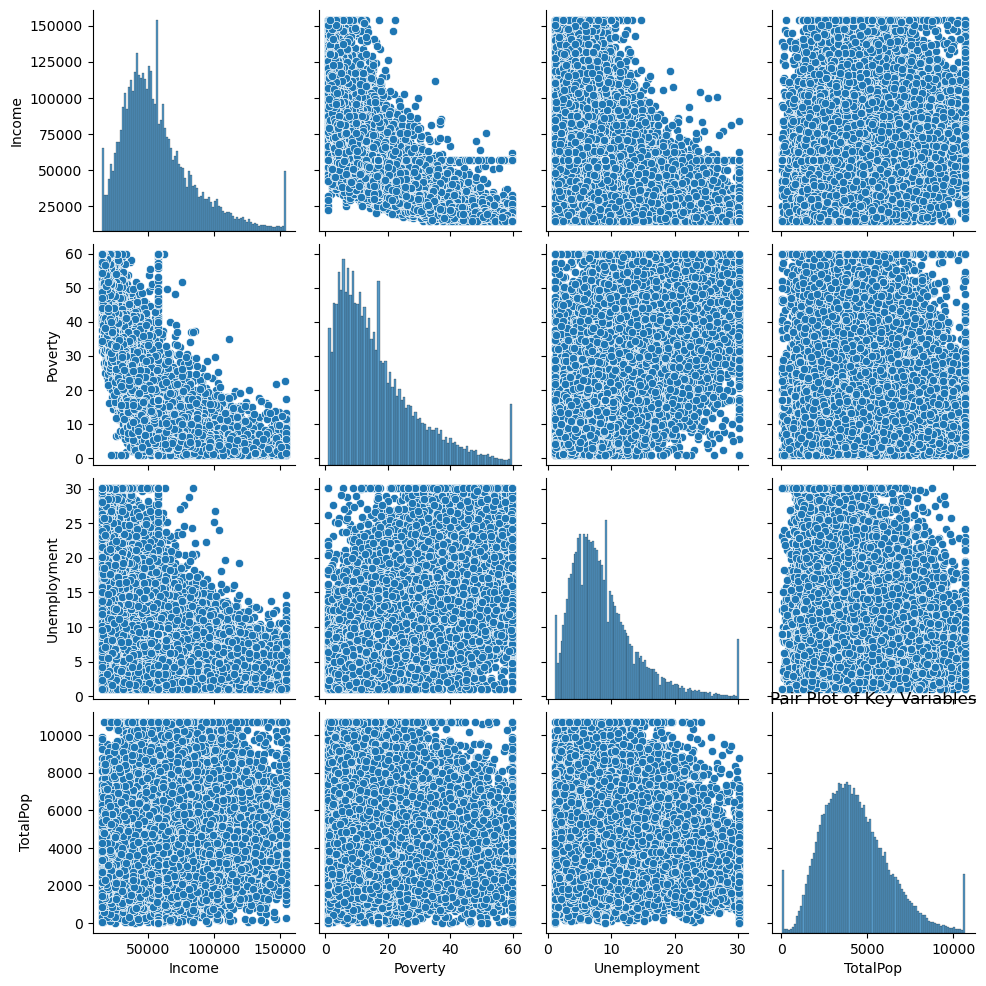

In [14]:
# Pair Plot for Exploring Pairwise Relationships

# Pair plot for Income, Poverty, Unemployment, and Total Population
sns.pairplot(df[['Income', 'Poverty', 'Unemployment', 'TotalPop']])
plt.title('Pair Plot of Key Variables')
plt.show()

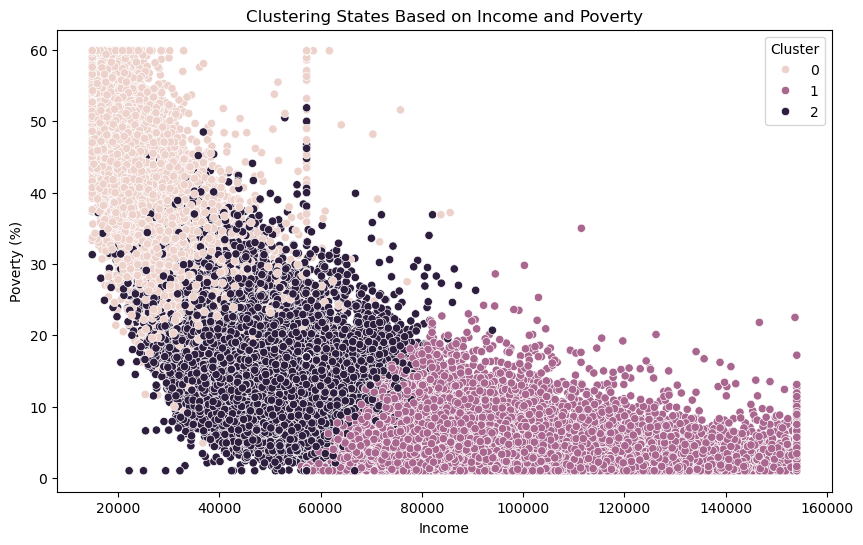

In [15]:
# Clustering for Segmentation

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Selecting numeric columns for clustering
cluster_data = df[['Income', 'Poverty', 'Unemployment']].dropna()

# Scaling the data (important for K-Means)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)

# Applying K-Means with 3 clusters (for example)
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_data)

# Visualize clusters (Income vs Poverty colored by cluster)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Income', y='Poverty', hue='Cluster', data=df)
plt.title('Clustering States Based on Income and Poverty')
plt.xlabel('Income')
plt.ylabel('Poverty (%)')
plt.show()